In [145]:
import pandas as pd
import numpy as np

In [70]:
dataset = pd.read_csv('smart_meters_london_2013.csv') 

In [71]:
dataset = dataset.T

In [72]:
dataset

,0,1,2,3,4,5,6,7,8,9,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
timestamp,2013-01-01 00:00:00,2013-01-01 01:00:00,2013-01-01 02:00:00,2013-01-01 03:00:00,2013-01-01 04:00:00,2013-01-01 05:00:00,2013-01-01 06:00:00,2013-01-01 07:00:00,2013-01-01 08:00:00,2013-01-01 09:00:00,...,2013-12-31 14:00:00,2013-12-31 15:00:00,2013-12-31 16:00:00,2013-12-31 17:00:00,2013-12-31 18:00:00,2013-12-31 19:00:00,2013-12-31 20:00:00,2013-12-31 21:00:00,2013-12-31 22:00:00,2013-12-31 23:00:00
0,0.46,0.426,0.411,0.395,0.221,0.206,0.206,0.217,0.216,0.216,...,0.62,1.034,0.841,0.747,0.477,0.559,1.233,0.783,0.858,0.943
1,3.888,2.603,2.159,2.04,1.495,1.044,0.807,0.227,0.15,0.231,...,0.252,0.127,0.174,0.192,0.113,0.221,0.14,0.12,0.484,0.149
2,0.0,0.158,0.0,0.17,0.0,0.0,0.176,0.0,0.176,0.0,...,0.24,0.0,0.0,0.147,0.0,0.169,0.0,0.178,0.0,0.157
3,0.207,0.106,0.069,0.065,0.058,0.068,0.069,0.086,0.447,0.092,...,0.253,0.12,0.134,0.199,1.042,0.281,0.286,0.209,0.467,0.282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4120,0.246,0.221,0.207,0.22,0.238,0.167,0.131,0.132,0.183,0.292,...,0.174,0.176,0.243,0.751,0.381,0.216,0.267,0.279,0.217,0.218
4121,0.141,0.131,0.131,0.104,0.119,0.123,0.091,0.138,0.229,0.326,...,0.692,0.783,0.928,0.496,0.413,0.649,0.263,0.294,0.282,0.187
4122,0.547,0.474,0.252,0.091,0.086,0.101,0.097,0.096,0.103,0.219,...,1.424,0.695,2.219,2.529,0.907,0.928,0.774,0.802,0.874,1.0
4123,0.215,0.227,0.22,0.202,0.208,0.181,0.264,0.251,0.217,0.235,...,0.221,0.221,0.219,0.205,0.209,0.22,0.221,0.22,0.17,0.168


<Axes: >

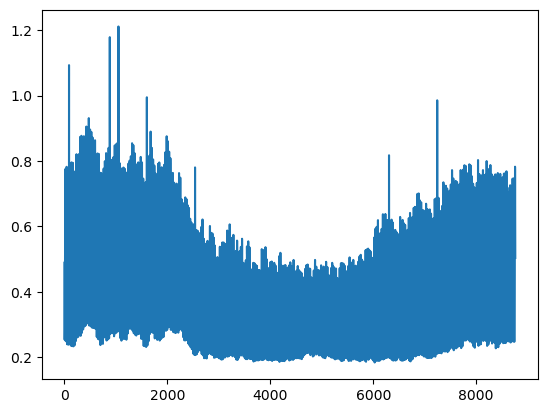

In [73]:
dataset.iloc[1:,:].mean(axis = 0).plot()

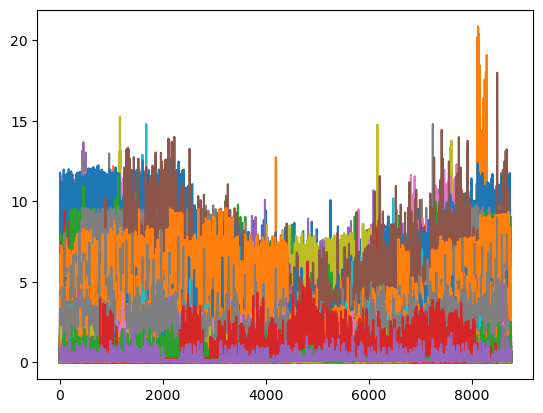

In [87]:
for i in range(1,dataset.shape[0]):
    dataset.iloc[i,:].plot()

<Axes: >

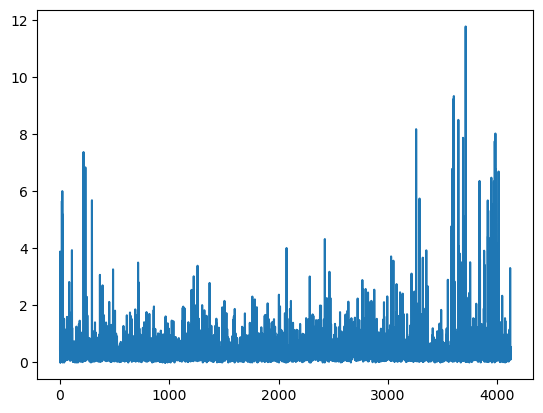

In [111]:
dataset.iloc[1:,0].plot()

In [117]:
mean = dataset.iloc[1:,0].mean()

<Axes: >

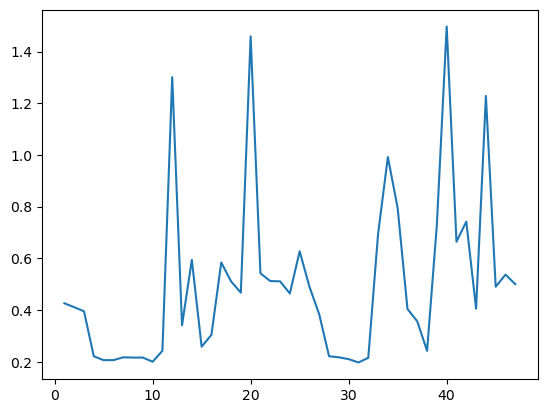

In [121]:
dataset.iloc[1,1:48].plot()

In [244]:
def train_test_split(dataset, train_split_index):
    train = dataset[1:(train_split_index + 1)]
    
    test = dataset[(train_split_index + 1):]

    return train, test



import torch
from torch import nn

class TimeSeriesVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, seq_len):
        super(TimeSeriesVAE, self).__init__()
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # Encoder (LSTM)
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder (LSTM)
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, batch_first=True)

    def encode(self, x):
        _, (h_n, _) = self.encoder_lstm(x)  # h_n: (1, batch_size, hidden_dim)
        h_n = h_n.squeeze(0)  # Remove the first dimension
        mean = self.fc_mean(h_n)
        logvar = self.fc_logvar(h_n)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        z = self.decoder_fc(z).unsqueeze(0)  # Add sequence dimension
        z = z.repeat(self.seq_len, 1, 1)  # Repeat for sequence length
        z = z.transpose(0, 1)  # Swap batch and sequence dimensions
        output, _ = self.decoder_lstm(z)
        return output

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mean, logvar



In [245]:
train_set, validation_set = train_test_split(dataset, train_split_index = 3200)
train_set

,0,1,2,3,4,5,6,7,8,9,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
0,0.46,0.426,0.411,0.395,0.221,0.206,0.206,0.217,0.216,0.216,...,0.62,1.034,0.841,0.747,0.477,0.559,1.233,0.783,0.858,0.943
1,3.888,2.603,2.159,2.04,1.495,1.044,0.807,0.227,0.15,0.231,...,0.252,0.127,0.174,0.192,0.113,0.221,0.14,0.12,0.484,0.149
2,0.0,0.158,0.0,0.17,0.0,0.0,0.176,0.0,0.176,0.0,...,0.24,0.0,0.0,0.147,0.0,0.169,0.0,0.178,0.0,0.157
3,0.207,0.106,0.069,0.065,0.058,0.068,0.069,0.086,0.447,0.092,...,0.253,0.12,0.134,0.199,1.042,0.281,0.286,0.209,0.467,0.282
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068,0.09,0.069,...,0.108,0.217,0.121,0.155,0.279,0.227,0.218,0.209,0.154,0.113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,0.514,0.381,0.146,0.174,0.183,0.183,0.216,0.213,0.223,0.202,...,1.424,0.442,0.593,0.443,0.66,0.594,0.56,0.406,0.35,0.346
3196,0.112,0.142,0.139,0.137,0.123,0.118,0.149,0.142,0.143,0.148,...,0.163,0.123,0.15,0.147,0.143,0.121,0.146,0.134,0.145,0.114
3197,0.561,0.415,0.365,0.354,0.356,0.367,0.37,0.495,0.407,0.39,...,0.287,0.292,0.301,0.363,0.386,0.408,0.398,0.383,0.417,0.384
3198,0.308,0.317,0.289,0.308,0.289,0.304,0.302,0.283,1.731,3.794,...,0.3,0.971,1.056,1.082,1.066,0.334,0.324,0.212,0.197,0.201


In [251]:
train_set.iloc[0:,0:].to_numpy().astype(np.float32)

array([[0.46 , 0.426, 0.411, ..., 0.783, 0.858, 0.943],
       [3.888, 2.603, 2.159, ..., 0.12 , 0.484, 0.149],
       [0.   , 0.158, 0.   , ..., 0.178, 0.   , 0.157],
       ...,
       [0.561, 0.415, 0.365, ..., 0.383, 0.417, 0.384],
       [0.308, 0.317, 0.289, ..., 0.212, 0.197, 0.201],
       [0.615, 0.329, 0.244, ..., 1.812, 0.56 , 0.591]], dtype=float32)

Epoch 1/20


/tmp/ipykernel_3658985/1651549749.py:13: UserWarning: Using a target size (torch.Size([32, 24])) that is different to the input size (torch.Size([1, 32, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  reconstruction_loss = nn.functional.mse_loss(reconstructed, x, reduction='sum')


Loss: 17.9712
Epoch 2/20
Loss: 17.8060
Epoch 3/20
Loss: 17.7953
Epoch 4/20
Loss: 17.8284
Epoch 5/20
Loss: 17.8457
Epoch 6/20
Loss: 17.7905
Epoch 7/20
Loss: 17.8082
Epoch 8/20
Loss: 17.8090
Epoch 9/20
Loss: 17.8552
Epoch 10/20
Loss: 17.7989
Epoch 11/20
Loss: 17.8545
Epoch 12/20
Loss: 17.8351
Epoch 13/20
Loss: 17.8012
Epoch 14/20
Loss: 17.8259
Epoch 15/20
Loss: 17.8048
Epoch 16/20
Loss: 17.8165
Epoch 17/20
Loss: 17.8174
Epoch 18/20
Loss: 17.8195
Epoch 19/20
Loss: 17.8362
Epoch 20/20
Loss: 17.8386


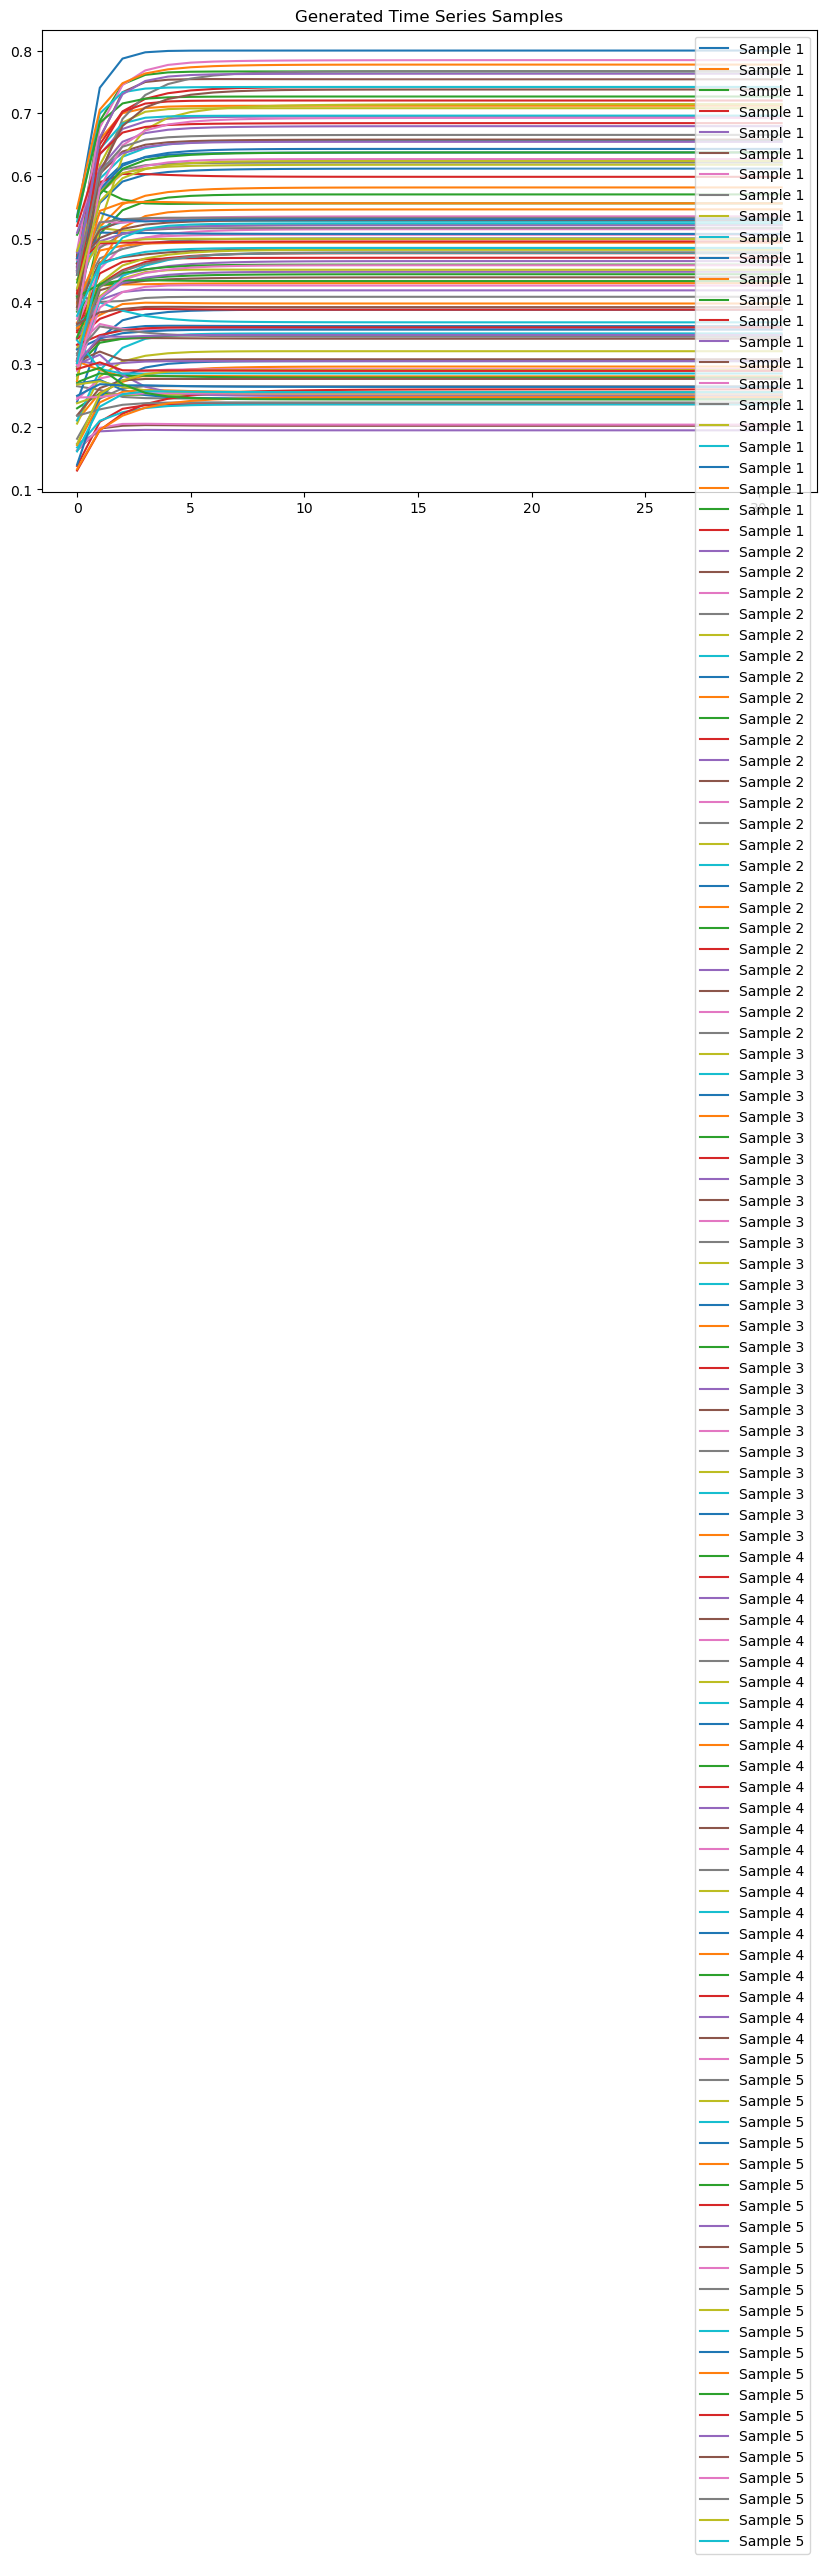

In [254]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess data
transform = transforms.Compose([transforms.ToTensor()])
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

# Loss function
def vae_loss(reconstructed, x, mean, logvar):
    reconstruction_loss = nn.functional.mse_loss(reconstructed, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

# Training setup
input_dim = 24 #train_set.shape[1]
hidden_dim = 16
latent_dim = 2
seq_len = 32
batch_size = 32

# Create synthetic dataset
train_loader = torch.utils.data.DataLoader(train_set.iloc[0:,0:input_dim].to_numpy().astype(np.float32), batch_size=batch_size, shuffle=False)

# Create VAE model
vae = TimeSeriesVAE(input_dim, hidden_dim, latent_dim, seq_len)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for batch in train_loader:
        batch = batch.to(device)

        #print(batch.shape)
        # Forward pass
        reconstructed, mean, logvar = vae(batch)

        # Compute loss
        loss = vae_loss(reconstructed, batch, mean, logvar)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Loss: {loss.item() / len(batch):.4f}")

# Generate samples from the latent space
def generate_samples(model, num_samples):
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated_sequences = model.decode(z).cpu()
    return generated_sequences

# Plot generated samples
samples = generate_samples(vae, 5)
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(samples[i].squeeze().numpy(), label=f"Sample {i + 1}")
plt.legend()
plt.title("Generated Time Series Samples")
plt.show()
